In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import quantumpropagator as qp
from quantumpropagator import readWholeH5toDict, abs2
#from __future__ import print_function
from ipywidgets import interact#, interactive, fixed, interact_manual
import ipywidgets as widgets

def heatThisP(h5File,first,second,vmaxV,state,sliced,which,save=None):
    aaa = np.rad2deg
    save = save or False
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    
    if which == 'phi':
        wf   = qp.retrieve_hdf5_data(h5File,'WF')[sliced,:,:,state]
        plt.xlabel('Gamma')
        plt.ylabel('Theta')
        ext = [aaa(first[0]),aaa(first[-1]),aaa(second[0])*2,aaa(second[-1])*2]
    
    elif which == 'gam':
        wf   = qp.retrieve_hdf5_data(h5File,'WF')[:,sliced,:,state]
        plt.xlabel('Phi')
        plt.ylabel('Theta')
        ext = [first[0],first[-1],aaa(second[0])*2,aaa(second[-1])*2]
        
    elif which == 'the':
        wf   = qp.retrieve_hdf5_data(h5File,'WF')[:,:,sliced,state]
        plt.xlabel('Phi')
        plt.ylabel('Gamma')
        ext = [first[0],first[-1],aaa(second[0]),aaa(second[-1])]
    
    time = qp.retrieve_hdf5_data(h5File,'Time')[0]
    fig = plt.figure(dpi= 80, facecolor='w', edgecolor='k')
    #fig = plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
    plt.title('Time = {:10.5f} fs'.format(time))

    
    # this is to get a nice colorbar on the side
    ax = plt.gca()

    im = ax.imshow(qp.abs2(wf), extent=ext, cmap='hot', vmax=vmaxV)
    #im = ax.imshow(qp.abs2(wf), cmap='PuBu_r', vmax=0.4)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    plt.colorbar(im, cax=cax)
    
    if save:
        fig.savefig(os.path.splitext(h5File)[0] + '.png')
        plt.close()

In [2]:
subfolders = sorted([ dir for dir in os.listdir('.') if os.path.isdir(dir) and dir != '.ipynb_checkpoints'])
print(''.join(['{} -> {}\n'.format(a,b) for a,b in enumerate(subfolders)]))

0 -> input_FinerGrid_0000
1 -> input_FinerGrid_0001
2 -> input_FinerGrid_0002
3 -> input_FinerGrid_0003
4 -> input_FinerGrid_0004
5 -> input_FinerGrid_0005
6 -> input_FinerGrid_0006
7 -> input_FinerGrid_0007
8 -> input_FinerGrid_0008
9 -> input_FinerGrid_0009
10 -> input_FinerGrid_0010
11 -> input_FinerGrid_0011
12 -> input_FinerGrid_0012



In [3]:
a = subfolders[-1]

In [4]:
filesList = [ fn for fn in sorted(os.listdir(a)) if fn[:8] == 'Gaussian' and fn[-3:] == '.h5']
outh5 = os.path.join(a,'allInput.h5')
dictio = readWholeH5toDict(outh5)
phis,gams,thes = dictio['phis'],dictio['gams'],dictio['thes']
lastV = len(filesList)-1
# dictio.keys()
zeroWF = qp.retrieve_hdf5_data(os.path.join(a,filesList[0]),'WF')
vmaxV = abs2(zeroWF).max()
phiL,gamL,theL,nstates = (qp.retrieve_hdf5_data(os.path.join(a,filesList[0]),'WF')).shape
phisT = phis
gamsT = np.rad2deg(gams)
thesT = np.rad2deg(thes)*2

# Phi Slices

In [5]:
def f_tg(frame,state,phi):
    return heatThisP(os.path.join(a,filesList[frame]),gams,thes,vmaxV,state,phi,'phi')

interact(f_tg, frame = widgets.IntSlider(min=0,max=lastV,step=1,value=lastV),state = widgets.IntSlider(min=0,max=nstates-1,step=1,value=0), phi = widgets.IntSlider(min=0,max=phiL-1,step=1,value=14));
createimages = False

interactive(children=(IntSlider(value=31, description='frame', max=31), IntSlider(value=0, description='state'…

# Gamma slices

In [6]:
def f_pt(frame, state, gamma):
    return heatThisP(os.path.join(a,filesList[frame]),phis,thes,vmaxV,state,gamma,'gam')

interact(f_pt, frame = widgets.IntSlider(min=0,max=lastV,step=1,value=lastV),state = widgets.IntSlider(min=0,max=nstates-1,step=1,value=0), gamma = widgets.IntSlider(min=0,max=gamL-1,step=1,value=9));

interactive(children=(IntSlider(value=31, description='frame', max=31), IntSlider(value=0, description='state'…

# Theta slices

In [7]:
def f_pg(frame, state, theta):
    return heatThisP(os.path.join(a,filesList[frame]),phis,gams,vmaxV,state,theta,'the')

interact(f_pg, frame = widgets.IntSlider(min=0,max=lastV,step=1,value=lastV),state = widgets.IntSlider(min=0,max=nstates-1,step=1,value=0), theta = widgets.IntSlider(min=0,max=theL-1,step=1,value=12));

interactive(children=(IntSlider(value=31, description='frame', max=31), IntSlider(value=0, description='state'…

# 1d slices

In [8]:
def sliceGammas(h5File, gamma, exa):
    wf  = qp.retrieve_hdf5_data(h5File,'WF')
    fig = plt.figure(figsize=(11, 6), dpi= 80, facecolor='w', edgecolor='k')
    ys = wf[gamma,:]*exa
    time = qp.retrieve_hdf5_data(h5File,'Time')[0]
    plt.title('Time = {:10.5f} fs --- gammaL = {:8.3f}'.format(time,gamsT[gamma]))
    plt.ylim(-0.5,0.5)
    plt.plot(thesT, np.real(ys), linewidth=1,ls='--')
    plt.plot(thesT, np.imag(ys), linewidth=1,ls='--')
    plt.plot(thesT, abs2(ys), linewidth=3,ls='-')

def sliceThetas(h5File, theta, exa):
    wf  = qp.retrieve_hdf5_data(h5File,'WF')
    fig = plt.figure(figsize=(11, 6), dpi= 80, facecolor='w', edgecolor='k')
    ys = wf[:,theta]*exa
    time = qp.retrieve_hdf5_data(h5File,'Time')[0]
    plt.title('Time = {:10.5f} fs --- thetaL = {:8.3f}'.format(time,thesT[theta]))
    plt.ylim(-0.5,0.5)
    plt.plot(gamsT, np.real(ys), linewidth=1,ls='--')
    plt.plot(gamsT, np.imag(ys), linewidth=1,ls='-.')
    plt.plot(gamsT, abs2(ys), linewidth=3,ls='-')    
    
def fgam(file_number,gamma,exa):
    return sliceGammas(os.path.join(a, filesList[file_number]), gamma, exa)

def fthe(file_number,theta,exa):
    return sliceThetas(os.path.join(a, filesList[file_number]), theta, exa)

In [9]:
#interact(fgam, file_number = widgets.IntSlider(min=0,max=lastV,step=1,value=lastV), gamma = widgets.IntSlider(min=0,max=gamL-1,step=1,value=10), exa = widgets.IntSlider(min=1,max=10,step=1,value=1));

In [10]:
#interact(fthe, file_number = widgets.IntSlider(min=0,max=lastV,step=1,value=lastV), theta = widgets.IntSlider(min=0,max=theL-1,step=1,value=16), exa = widgets.IntSlider(min=1,max=10,step=1,value=1));

In [11]:
outfn = os.path.join(a,'output')
outfnP = os.path.join(a,'outputPopul')

In [12]:
data = pd.read_csv(outfn, delim_whitespace=True, header=None);
dataP = pd.read_csv(outfnP, delim_whitespace=True, header=None);
data.columns = ['steps','fs','Norm Deviation','Kinetic','Potential','Total','Total deviation','Xpulse','Ypulse','Zpulse']

In [13]:
result = pd.concat([data, dataP], axis=1)
result

,steps,fs,Norm Deviation,Kinetic,Potential,Total,Total deviation,Xpulse,Ypulse,Zpulse,0,1,2,3,4,5,6,7,8
0,0,0.000000,-2.220446e-16,0.083084,0.128030,0.211114,0.000000,3.719408e-09,3.719408e-09,3.719408e-09,0.0000,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,50,0.050050,4.362104e-06,0.083114,0.127997,0.211111,0.000003,4.500942e-09,4.500942e-09,4.500942e-09,0.0500,0.999991,2.241420e-17,1.809820e-22,2.536380e-25,1.211210e-18,3.833750e-19,1.256790e-18,1.500310e-18
2,100,0.100099,1.744442e-05,0.083202,0.127900,0.211101,0.000013,4.264817e-09,4.264817e-09,4.264817e-09,0.1001,0.999965,9.242090e-17,7.191960e-22,1.031770e-24,4.919770e-18,1.478180e-18,4.894340e-18,5.916830e-18
3,150,0.150149,3.923525e-05,0.083341,0.127744,0.211085,0.000029,2.323231e-09,2.323231e-09,2.323231e-09,0.1501,0.999922,1.690900e-16,1.247240e-21,1.851690e-24,8.802380e-18,2.458360e-18,8.247170e-18,1.014350e-17
4,200,0.200199,6.971599e-05,0.083525,0.127537,0.211062,0.000052,-1.908942e-09,-1.908942e-09,-1.908942e-09,0.2002,0.999861,1.804760e-16,1.326710e-21,1.974110e-24,9.384280e-18,2.604520e-18,8.749850e-18,1.078100e-17
5,250,0.250248,1.088622e-04,0.083744,0.127289,0.211033,0.000081,-8.627722e-09,-8.627722e-09,-8.627722e-09,0.2502,0.999782,1.839580e-16,1.858680e-21,2.292210e-24,1.127860e-17,4.192840e-18,1.363450e-17,1.597780e-17
6,300,0.300298,1.566448e-04,0.083990,0.127008,0.210998,0.000116,-1.728873e-08,-1.728873e-08,-1.728873e-08,0.3003,0.999687,6.363940e-16,6.731090e-21,8.142910e-24,4.060220e-17,1.493220e-17,4.887820e-17,5.803830e-17
7,350,0.350347,2.130310e-04,0.084259,0.126698,0.210956,0.000158,-2.627271e-08,-2.627271e-08,-2.627271e-08,0.3503,0.999574,2.501750e-15,2.231830e-20,2.979650e-23,1.463600e-16,4.552930e-17,1.517090e-16,1.865640e-16
8,400,0.400397,2.779853e-04,0.084546,0.126362,0.210909,0.000206,-3.270009e-08,-3.270009e-08,-3.270009e-08,0.4004,0.999444,6.732990e-15,5.239490e-20,7.593110e-23,3.676120e-16,9.931810e-17,3.352080e-16,4.243050e-16
9,450,0.450447,3.514691e-04,0.084854,0.126001,0.210855,0.000260,-3.256318e-08,-3.256318e-08,-3.256318e-08,0.4504,0.999297,1.297300e-14,8.995930e-20,1.398770e-22,6.679700e-16,1.592060e-16,5.427020e-16,7.044390e-16


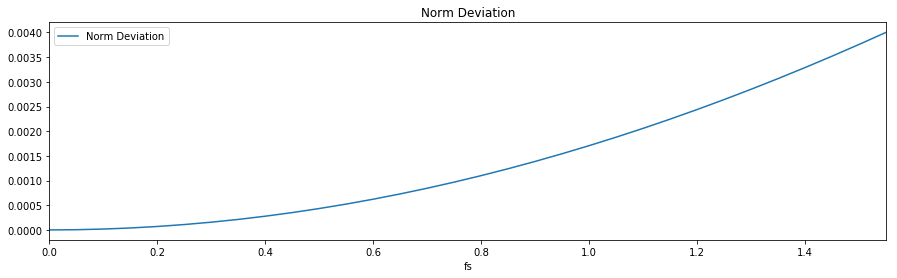

In [14]:
data.plot(title = 'Norm Deviation', x='fs', y = 'Norm Deviation', figsize=(15,4));

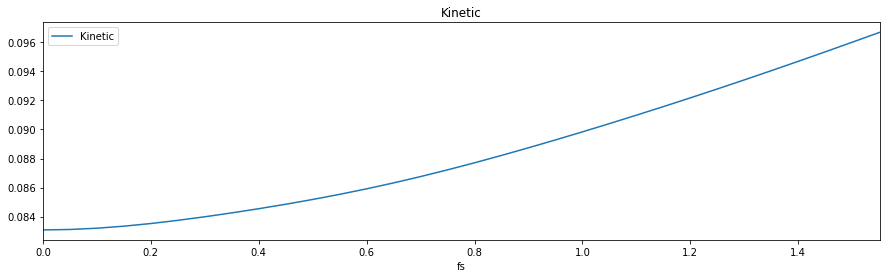

In [15]:
data.plot(title = 'Kinetic', x='fs', y = 'Kinetic', figsize=(15,4));

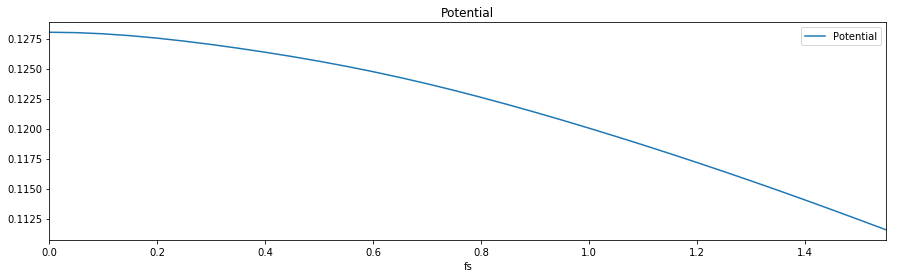

In [16]:
data.plot(title = 'Potential', x='fs', y = 'Potential', figsize=(15,4));

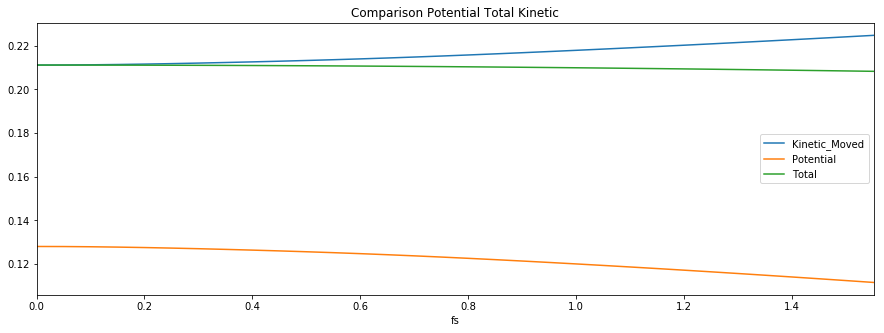

In [17]:
data['Kinetic_Moved'] = data['Kinetic'] + data['Potential'][0]
data.plot(title = 'Comparison Potential Total Kinetic', x=['fs'] ,y=['Kinetic_Moved','Potential','Total'], figsize=(15,5));

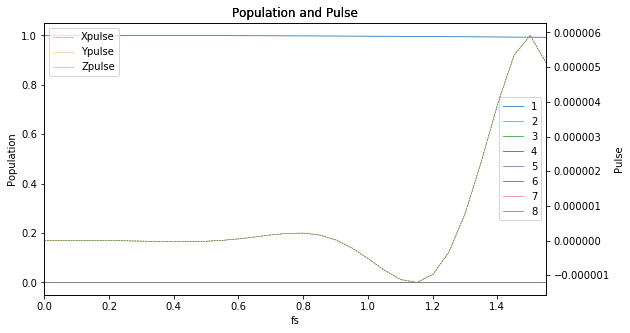

In [18]:
fig = plt.figure(figsize=(9,5))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax1.set_ylabel('Population')
ax2.set_ylabel('Pulse')
popul = np.arange(nstates)+1
result.plot(title = 'Population and Pulse', ax = ax1,  x=['fs'] ,y=popul, linewidth=0.8)
result.plot(title = 'Population and Pulse', ax = ax2,  x=['fs'] ,y=['Xpulse','Ypulse','Zpulse'], linewidth=0.5,ls='--');


### Expected values

In [19]:
def expected(h5file):
    wf  = qp.retrieve_hdf5_data(h5file,'WF')
    _,_,nstates = wf.shape
    for i in range(nstates):
        wfState = wf[:,:,i]
        popu = np.linalg.norm(wfState) # this is norm, the real popu is this squared
        if popu == 0:
            print('Expected Values State {}:\nPopul: {:10.3f} \nTheta: - \nGamma: -'.format(i, popu**2, theA, gamA))
        else:
            wfA = abs2(wfState/popu)
            gamAvg = np.sum(wfA,axis=1)
            theAvg = np.sum(wfA,axis=0)
            gamA = sum([ gamsT[i] * gamAvg[i] for i in range(gamAvg.size) ])
            theA = sum([ thesT[i] * theAvg[i] for i in range(theAvg.size) ])
            print('Expected Values State {}:\nPopul: {:10.3f} \nTheta: {:10.3f} \nGamma: {:10.3f}'.format(i, popu, theA, gamA))

def fexp(x):
    return expected(os.path.join(a,filesList[x]))

In [20]:
#interact(fexp, x = widgets.IntSlider(min=0,max=lastV,step=1,value=lastV));